Script for analysing output, including:  
* Transform the fitted data: generate a lattice parameter-temperature table for plotting  
* Visualise eigenvalue distribution: generate a matrix indicating the negative eigenvalues
* Visualise the temperature dependency of lattice parameters

Note: Plots of expansion probably not applicable to rhombohedral lattices: The first 3 parameters will be recoginzed as lengths!

By Spica. Vir., ICL, Mar 23 - 22. spica.h.zhou@gmail.com

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.patches import Circle

In [51]:
class Exp_data:
    """
    Class expansion data, store the lattice parameters and their variation with temperature.
    """
    def __init__(self, temperature=[], helmholtz=[], latt=[]):
        """
        temperature: 1d np array of temperature sequence
        helmholtz: 1d np array of Helmholtz free energy
        latt: 2d (ntemperature * nlatt) np matrix of irreducible lattice parameters
        """
        self.temperature = temperature
        self.helmholtz = helmholtz
        self.latt = latt
    
    def plot_expan(self, dimension=0):
        fig_expan = plt.figure(1)
        plt.clf() 
        ax_len = plt.subplot(1,2,1)
        
        latt_plt = self.latt.transpose().tolist()
        color_generate = Colorscale(mi=1, mx=len(latt_plt))
        
        if len(latt_plt) > 3: 
            ax_ang = ax_len.twinx()
        
        for i in range(len(latt_plt)): 
            line = np.array(latt_plt[i], dtype=float)
            line_color = color_generate.scale_color(inpdata=i + 1)
            if i <= 2:
                ax_len.plot(self.temperature, line, color=line_color)
            else:
                ax_ang.plot(self.temperature, line, color=line_color)
        
        ax_fe = plt.subplot(1,2,2)
        ax_fe.plot(self.temperature, self.helmholtz, color='black')
        plt.show()
        
    
    def write_out(self): 
        dimension = np.size(self.latt, 1)
        namelist = ''
        for i in range(dimension):
            namelist = namelist + '    LATT ' + str(i)
        
        wtout = open('thermal_expansion.dat', 'w')
        
        wtout.write('%-12s%12s%-s\n' % ('TEMPERATURE', 'HELMHOLTZ', namelist))
        for i in range(len(self.temperature)): 
            wtout.write('%12.2f%12.4f' % (self.temperature[i], self.helmholtz[i]))
            for j in range(dimension): 
                wtout.write('%10.4f' % self.latt[i, j])
            
            wtout.write('\n')
        
        wtout.close()
        
        self.plot_expan(dimension=dimension)
    
        
    

In [3]:
class Hess_data:
    """
    Class Hessian data, store the eigenvalue and corresponding eigenvectors
    """
    def __init__(self, temperature=[], eigs=[], eigv=[]):
        """
        temperature: 1d np array of temperature sequence
        eigs: 2d (ntemperature * nlatt) np array of eigenvalues of Hessian
        eigv: 2d (ntemperature * nlatt) list of eigenvectors (string)
        """
        self.temperature = temperature
        self.eigs = eigs
        self.eigv = eigv
        
    def analyze(self):
        eigslist = [j for i in self.eigs for j in i]
        if min(eigslist) > 0:
            msg = 'No negative value.'
            return msg, self
        
        self.eigs_mi = min(eigslist)
        self.eigs_mx = max(eigslist)
        
        negative = []
        dimension = len(eigs[0])
        for i in range(len(self.temperature)): 
            color_tmp = []
            for j in range(dimension):
                if eigs[i][j] < 0: 
                    negative.append([self.temperature[i], 
                                     j + 1, 
                                     self.eigs[i][j], 
                                     self.eigv[i][j]])
        
        return negative, self
    
    def plot_distr(self, neg):
        color_generate = Colorscale(mi=self.eigs_mi, mx=0)
        ndimen = len(self.eigs[0])
        
        fig_hess = plt.figure(2)
        ax_hess = plt.subplot(1,1,1)
        
        for i in neg:
            cir_color = color_generate.scale_color(inpdata=i[2])
            xy = (i[1], i[2]) 
            point = Circle(xy, radius=5, facecolor=cir_color)
            plt.gca().add_patch(point)
            
        plt.xlim(min(self.temperature) - 5, max(self.temperature) + 5)
        plt.ylim(0.5, len(self.eigs[0]) + 0.5)
        plt.show()
    
    def write_out(self):
        neg, self = self.analyze()
        if isinstance(neg, str):
            print(neg)
            return
        
        wtout = open('negative_eigs.dat', 'w')
        wtout.write('%-12s%-4s%-12s%-12s\n' % ('TEMPERATURE', 'NU','EIGEN VALUE', 'VECTOR'))
        for i in neg:
            wtout.write('%-12.2f%-4i%12.6f%s\n' % (i[0], i[1], i[2], i[3]))
        
        wtout.close()
        
        self.plot_distr(neg=neg)

In [52]:
class Colorscale: 
    
    def __init__(self, divid=100, colormap=[[0, 0, 1],
                                            [0, 1, 1],
                                            [0, 1, 0],
                                            [1, 1, 0],
                                            [1, 0, 0]], mi=0, mx=99):
        colormap = np.matrix(colormap, dtype=float)
        colormap = colormap.transpose()
        
        residue = divid % (np.size(colormap, 1) - 1)
        divid -= residue
        div_per_range = int(divid / (np.size(colormap, 1) - 1))
        
        colormx = []
        for i in range(3):
            colorarray = []
            for j in range(np.size(colormap, 1) - 1):
                rangearray = np.linspace(colormap[i, j], 
                                         colormap[i, j + 1], 
                                         div_per_range + 1)
                rangearray = rangearray[: -1].tolist()
                colorarray = colorarray + rangearray
            
            colorarray.append(colormap[i, -1])
            colormx.append(colorarray)
                
        colormx = np.around(np.matrix(colormx, dtype=float), 3)
        
        self.colormap = colormx.transpose().tolist()
        self.mx = mx
        self.mi = mi
        self.divid = divid
        
    def scale_color(self, inpdata):
        if self.mi == self.mx: 
            data_color = [0.7451, 0.7451, 0.7451]
            return data_color
        
        if self.mi > self.mx: 
            inter = self.mx
            self.mx = self.mi
            self.mi = inter
        
        color_pos = round((inpdata - self.mi) / (self.mx - self.mi) * self.divid)
        data_color = self.colormap[color_pos]
        
        return data_color

In [5]:
def readfile(inputfile):
    label_exp = 'TTTTTTTTTTTTTTTTTTTTTTTT'
    label_hess = 'EIGENVALUES'
    
    countline = 0
    data_plt = Exp_data()
    data_mx = Hess_data()
    
    while countline < len(inputfile):
        if label_exp in inputfile[countline]:
            countline += 2
            temp = inputfile[countline].strip().split()[2]
            countline += 1
            helm = inputfile[countline].strip().split()[3]
            countline += 3
            latt = inputfile[countline].strip().split()
            data_plt.temperature.append(temp)
            data_plt.helmholtz.append(helm)
            data_plt.latt.append(latt)
        
        elif label_hess in inputfile[countline]:
            countline += 1
            data_mx.temperature = temp
            eigs = []
            eigv = []
            while len(inputfile[countline].strip().split()) > 0:
                line = inputfile[countline].strip().split()
                eigs.append(line[0])
                for i in line[3 :]: 
                    eigv.append(i + '    ')
                    
                countline += 1
            
            data_mx.eigs.append(eigs)
            data_mx.eigv.append(eigv)
        
        countline += 1
        
    data_plt.temperature = np.array(data_plt.temperature, dtype=float)
    data_plt.helmholtz = np.array(data_plt.helmholtz, dtype=float)
    data_plt.latt = np.matrix(data_plt.latt, dtype=float)
        
    data_mx.temperature = np.array(data_mx.temperature, dtype=float)
    data_mx.eigs = np.array(data_mx.eigs, dtype=float)
    
    return data_plt, data_mx

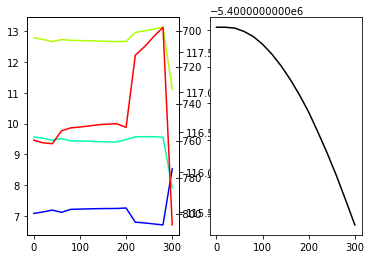

In [53]:
file = open('QHA_fit.dat', "r")
data_in = file.readlines()
file.close()

latt_exp, hess_eigs = readfile(data_in)
latt_exp.write_out()